In [ ]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langchain_core.documents import Document
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pydantic import BaseModel, Field
from typing import Annotated, TypedDict, Optional, Literal
import json
import logging
import os
from dotenv import load_dotenv
import datetime

from pydantic import Field

from backend.app.client import tools, book_appointment, check_availability


In [ ]:
load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
model = ChatGroq(
    model="llama-3.1-8b-instant",
    api_key=GROQ_API_KEY
)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

#langgraph state
class AgentState(TypedDict):
    extracted_data: dict
    messages: Annotated[list[AnyMessage], add_messages]


In [5]:
res = model.invoke("Hello, world!")
print(res)


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


content="Hello, world. It's nice to meet you. Is there something I can help you with, or would you like to chat?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 39, 'total_tokens': 67, 'completion_time': 0.041796999, 'completion_tokens_details': None, 'prompt_time': 0.009322904, 'prompt_tokens_details': None, 'queue_time': 0.055661215, 'total_time': 0.051119903}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019bd5d0-e9d8-72d2-a955-025ae243f255-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 39, 'output_tokens': 28, 'total_tokens': 67}


In [2]:

PROMPT = """ You are a professional appoitment and reporting assistant. 
Your task is to chat with customers, understand their needs regarding medical appointments,
and assist them in booking appointment, checking availablity using the tools provided.

If information is missing for tool calling ask the user for missing information.

Once the task is done stop the conversation by thanking the user. Don't call any tool after that.
"""


In [10]:
from langchain_groq.chat_models import ChatGroq
from typing import TypedDict, Annotated, Optional
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode


import os
from dotenv import load_dotenv

from app.client import tools
# from utils.utils import logger
from utils.utils import get_today_date

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

model = ChatGroq(
    model="llama-3.1-8b-instant",
    api_key=GROQ_API_KEY,
    temperature=0
)

PROMPT = """ You are a professional appoitment and reporting assistant. 
Your task is to chat with customers, understand their needs regarding medical appointments,
and assist them in booking appointment, checking availablity using the tools provided.

If information is missing for tool calling ask the user for missing information.

Once the task is done stop the conversation by thanking the user. Don't call any tool after that.
"""


class AgentState(TypedDict):
    human_input: str
    messages: Annotated[list[AnyMessage], add_messages]


def agent_with_tools(state: AgentState):
    llm_with_tools = model.bind_tools(tools)

    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
    }
  
def build_prompt(state):
    messages = state["messages"].copy()
    messages.insert(0, SystemMessage(content=PROMPT.strip()))
    return {"messages": messages}

def should_continue(state: AgentState) -> str:
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "continue"
    return "end"

def build_agent_graph() -> StateGraph:
    graph = StateGraph(AgentState)
    
    # Streamlined Nodes
    graph.add_node("agent", agent_with_tools)
    graph.add_node("build_prompt", build_prompt)
    graph.add_node("tools", ToolNode(tools))

    graph.add_edge(START, "build_prompt")
    graph.add_edge("build_prompt", "agent")
    graph.add_conditional_edges(
        "agent", 
        should_continue, 
        {
            "continue": "tools", 
            "end": END
        }
    )
    graph.add_edge("tools", "agent")

    # logger.info("Agent graph successfully built.")
    return graph.compile()

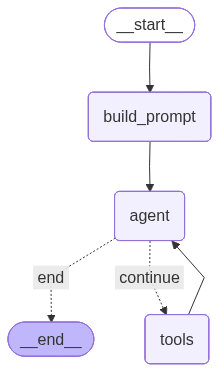

In [12]:
r = build_agent_graph()
r

In [18]:
question = "I would like to book an appointment with Dr. Smith today at 3 PM."
state: AgentState = {"messages": [HumanMessage(content=question)]}
res = r.invoke(state)

Booking appointment with payload: {'doctor_name': 'Dr. Smith', 'appointment_date': '2024-01-19'}


In [19]:
res['messages']

[HumanMessage(content='I would like to book an appointment with Dr. Smith today at 3 PM.', additional_kwargs={}, response_metadata={}, id='981a9f84-66bc-4286-9904-0a364d748e71'),
 SystemMessage(content="You are a professional appoitment and reporting assistant. \nYour task is to chat with customers, understand their needs regarding medical appointments,\nand assist them in booking appointment, checking availablity using the tools provided.\n\nIf information is missing for tool calling ask the user for missing information.\n\nOnce the task is done stop the conversation by thanking the user. Don't call any tool after that.", additional_kwargs={}, response_metadata={}, id='5813d248-281e-4d92-b0f4-d5496652a4cb'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9kw637mbr', 'function': {'arguments': '{"appointment_date":"2024-01-19","appointment_time":"15:00","doctor_name":"Dr. Smith","reason":"General consultation"}', 'name': 'book_appointment'}, 'type': 'function'}]}, resp